# Import necessary modules and models.

In [1]:
# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(123)

# Import model
from model import DigitClassifierCNN

digit_classifier = DigitClassifierCNN()

In [2]:
# try random 28x28 input

# Dimensions: nSamples x nChannels x Height x Width
# pytorch only supports mini-batches so the first dim needs to be 1
i = torch.randn(1, 1, 28, 28)

out = digit_classifier(i)
print(out)

tensor([[ 0.0908,  0.0781,  0.0727, -0.0637,  0.0313,  0.0291,  0.1366,  0.0625,
         -0.0585, -0.1560]], grad_fn=<AddmmBackward0>)


# Data loading and exploration.

In [3]:
import torchvision
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

data_transform = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True), 
                        v2.Normalize((0.5,), (0.5,)),])

data = MNIST("./data/", train=True, download=True, transform=data_transform)
train_data, val_data = torch.utils.data.random_split(data, [50000, 10000])
test_data = MNIST("./data/", train=False, download=True, transform=data_transform)

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

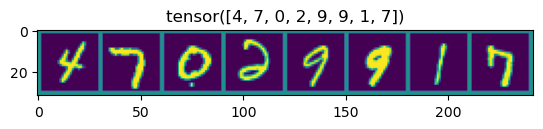

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, labels):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(npimg) #, cmap="Greys")
    plt.title(labels)

# Extract a batch of 4 images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, labels)

In [5]:
from torch.utils.tensorboard import SummaryWriter

# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/mnist_digit_classification')

# Write image data to TensorBoard log dir
writer.add_image('Eight mnist digits', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

# Training loop

In [6]:
# Move to gpu for training if available.
if torch.cuda.is_available(): 
    device = "cuda:0" 

digit_classifier.to(device)

DigitClassifierCNN(
  (transform): Compose(
        Resize(size=[28, 28], interpolation=InterpolationMode.BILINEAR, antialias=True)
        Grayscale(num_output_channels=1)
  )
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [7]:
import torch.optim as optim

# Define optimizer and loss functions
optimizer = optim.Adam(digit_classifier.parameters(), lr=0.001)
# optimizer = optim.SGD(digit_classifier.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train_one_epoch(epoch_index, tb_writer):
    digit_classifier.train()
    
    running_loss = 0.
    last_loss = 0.
    
    for i, (x, y) in enumerate(train_dataloader):

        x, y = x.to(device), y.to(device)
        
        # Compute gradients and update for each minibatch
        optimizer.zero_grad()   # zero the gradient buffers
        y_hat = digit_classifier(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()    # Does the update
        
        # Log every 1000
        running_loss += loss.item()
        
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print("    batch: {}  loss: {}".format(i+1, last_loss))
            
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            
            running_loss = 0.
        
    return last_loss

In [8]:
from datetime import datetime

epoch_num = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [19]:
num_epochs = 10
best_vloss = 100000

for i in range(num_epochs):
    
    print("EPOCH:", epoch_num)
    
    # Train one epoch
    train_loss = train_one_epoch(i, writer)
    
    # Calculate validation loss. Then plot vs training loss.
    v_running_loss = 0.
    digit_classifier.eval()
    
    with torch.no_grad():
        for i, (v_x, v_y) in enumerate(val_dataloader):
            v_x, v_y = v_x.to(device), v_y.to(device)
            v_y_hat = digit_classifier(v_x)
            v_running_loss += criterion(v_y_hat, v_y)
        
    avg_vloss = v_running_loss / len(val_dataloader)
    
    print('LOSS train {} valid {}'.format(train_loss, avg_vloss))
    
    digit_classifier.train()
    writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : train_loss, 'Validation' : avg_vloss },
                      epoch_num * len(train_dataloader) + i)
    writer.flush()
    
    # Save model if we have a better performance
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        model_path = 'saves/digit_classifier_{}_{}'.format(timestamp, epoch_num)
        torch.save(digit_classifier.state_dict(), model_path)
    
    epoch_num += 1
        
        

EPOCH: 10
    batch: 1000  loss: 0.06440188462060786
    batch: 2000  loss: 0.06799878926659164
    batch: 3000  loss: 0.06809095063517592
    batch: 4000  loss: 0.06141328438527171
    batch: 5000  loss: 0.06662827787950033
    batch: 6000  loss: 0.07117332991768262
LOSS train 0.07117332991768262 valid 0.04018488526344299
EPOCH: 11
    batch: 1000  loss: 0.06313737803989465
    batch: 2000  loss: 0.05363044340095712
    batch: 3000  loss: 0.05581689800582551
    batch: 4000  loss: 0.06502852011568791
    batch: 5000  loss: 0.06263650117184193
    batch: 6000  loss: 0.06046379272576939
LOSS train 0.06046379272576939 valid 0.04295845329761505
EPOCH: 12
    batch: 1000  loss: 0.05202238963546427
    batch: 2000  loss: 0.05641709293659642
    batch: 3000  loss: 0.06472995569740408
    batch: 4000  loss: 0.061446205106482465
    batch: 5000  loss: 0.06700294237079277
    batch: 6000  loss: 0.05675468119685533
LOSS train 0.05675468119685533 valid 0.04601527750492096
EPOCH: 13
    batch: 100

In [20]:
# Converged around 9-10 epochs.

In [21]:
# Error analysis

img_errors = torch.empty(0, dtype=torch.int64).to(device)
true_labels = torch.empty(0, dtype=torch.int64).to(device)
labels_errors = torch.empty(0, dtype=torch.int64).to(device)

digit_classifier.eval()
for i, (imgs, labels) in enumerate(val_dataloader):
    imgs, labels = imgs.to(device), labels.to(device)
    
    pred = digit_classifier(imgs)
    pred_labels = torch.argmax(pred, axis=1)
    
    img_errors = torch.cat((img_errors, imgs[labels != pred_labels]), 0)
    true_labels = torch.cat((true_labels, labels[labels != pred_labels]), 0)
    labels_errors = torch.cat((labels_errors, pred_labels[labels != pred_labels]), 0)



In [22]:
print(true_labels.shape[0] == img_errors.shape[0])
print(img_errors.shape[0])

print("Val accuracy:", 1 - img_errors.shape[0]/len(val_dataloader))

True
96
Val accuracy: 0.9232


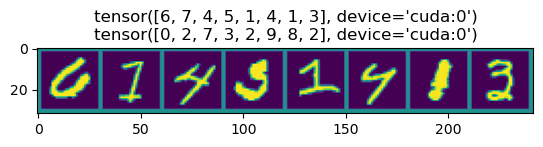

In [18]:
batch_size = 8

sample_indices = np.random.choice(range(true_labels.shape[0]), batch_size, replace=False)

# Create a grid from the images and show them
imgs = img_errors[sample_indices]
true_label = true_labels[sample_indices]
pred_labels = labels_errors[sample_indices]
img_grid = torchvision.utils.make_grid(imgs)
matplotlib_imshow(img_grid, 
                  str(true_label) + "\n" + str(pred_labels))



In [14]:
len(train_dataloader)

6250